Ok, here's what's up: I want to see which query produced the data

select SOURCEID, MEANMJDOBS, s.RA, s.DEC, JMHPNT, JMHPNTERR, HMKPNT,
               HMKPNTERR, JAPERMAG3, JAPERMAG3ERR, HAPERMAG3, HAPERMAG3ERR,
               KAPERMAG3, KAPERMAG3ERR, JPPERRBITS, HPPERRBITS, KPPERRBITS,
               MERGEDCLASS, PSTAR from wserv11SourceXSynopticSourceBestMatch as b,
               wserv11SynopticMergeLog as l, wserv11SynopticSource as s where
               b.synFrameSetID=s.synFrameSetID and b.synSeqNum=s.synSeqNum and
               b.synFrameSetID=l.synFrameSetID and s.RA > 0 order by SOURCEID,
               MEANMJDOBS

In [106]:
# get and process the data
import numpy as np
import matplotlib.pyplot as plt

from astropy.table import Table
dat = Table.read('WSERV11_results6_23_31_38_30286.fits', format='fits')

# this is the so-called error correction of Hodgkin 2009, which makes the 
# error bar estimates more grounded in reality (they are otherwise unrealistically
# low for bright stars) — there's a 2% (0.02 mag) noise floor in practice that 
# is not captured in the pipeline-produced error estimates.
dat['JAPERMAG3ERR'] = (1.082 * dat['JAPERMAG3ERR']**2 + 0.021**2)**0.5
dat['HAPERMAG3ERR'] = (1.082 * dat['HAPERMAG3ERR']**2 + 0.021**2)**0.5
dat['KAPERMAG3ERR'] = (1.082 * dat['KAPERMAG3ERR']**2 + 0.021**2)**0.5

df = dat.to_pandas() 

In [107]:
dat['JAPERMAG3'].min()
# dat[0]

-999999500.0

In [108]:
# a first cleaning, to remove the `empty`-flagged 

skimmed_df = df[
    (df['JAPERMAG3'] > 0) &
    (df['HAPERMAG3'] > 0) &
    (df['KAPERMAG3'] > 0) 
]



# okay, so we want to select a "pure" group of SOURCEIDs. This will require aggregating 
# the following kinds of information:
# - the max JPPERRBITS flags
# - possibly, the min magnitude (to avoid saturation and near-saturation, 
#   which destroy repeatable photometric measurements)
# - between 60 and 150

# plt.hist(df.groupby('SOURCEID')['JAPERMAG3'].aggregate('count'), bins=30)
# print(np.median(df.groupby('SOURCEID')['JAPERMAG3'].aggregate('count')))

df_groupby = skimmed_df.groupby('SOURCEID')

df_maxes = df_groupby.aggregate(np.nanmax)
df_mins = df_groupby.aggregate(np.nanmin)
df_medians = df_groupby.aggregate(np.nanmedian)
df_counts = df_groupby['JAPERMAG3'].aggregate('count')

In [109]:
df_maxes

,MEANMJDOBS,RA,DEC,JMHPNT,JMHPNTERR,HMKPNT,HMKPNTERR,JAPERMAG3,JAPERMAG3ERR,HAPERMAG3,HAPERMAG3ERR,KAPERMAG3,KAPERMAG3ERR,JPPERRBITS,HPPERRBITS,KPPERRBITS,MERGEDCLASS,PSTAR
SOURCEID,,,,,,,,,,,,,,,,,,
45195940855830,57686.570787,1.599797,-0.118159,0.596958,0.196662,0.246111,0.474315,19.156670,0.151093,18.820068,0.158638,19.121420,0.473717,557056,557056,4718592,-1,0.999657
45195940855837,57686.570787,1.599795,-0.117909,0.237066,0.202626,0.547632,0.285994,19.130194,0.129361,18.893127,0.169032,18.345495,0.246596,557056,557056,4718592,-1,0.944606
45195940855839,57773.394310,1.599795,-0.117660,0.731810,0.216538,0.764477,0.299516,19.122360,0.142868,18.768049,0.176647,18.519331,0.266583,4718592,557056,4718592,1,0.999657
45195940855842,57782.303056,1.599794,-0.117412,0.882273,0.213009,0.516148,0.354540,18.798622,0.176848,18.233923,0.149434,18.637789,0.348946,4718592,557056,4718592,-1,0.999657
45195940855843,57782.303056,1.599793,-0.117162,1.302280,0.192484,1.881401,0.196508,18.238310,0.179474,18.497963,0.198433,17.584429,0.162584,4718656,4718656,4718592,0,0.944606
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45195940912754,57781.475197,1.602437,-0.103848,0.575273,0.001133,1.366073,0.000956,10.523249,0.021018,10.113549,0.021015,10.208813,0.021013,65552,65552,65552,-1,0.999657
45195940912784,57782.305972,1.602932,-0.103645,0.694080,0.065917,0.389586,0.067254,16.385181,0.042110,15.724549,0.061727,15.427302,0.044338,16,16,16,1,0.000171
45195940912789,57670.583356,1.601397,-0.103576,1.088469,0.289910,0.936012,0.188354,19.760071,0.269979,18.671602,0.137598,17.735590,0.142601,0,0,0,1,0.052478


In [47]:
# df_medians = df_groupby.apply(np.median, axis=0)
df_medians = df_groupby.aggregate(np.median)

# df_groupby?

In [110]:
index_selection = (
    (df_medians['JPPERRBITS'] == 0) & 
    (df_medians['HPPERRBITS'] == 0) & 
    (df_medians['KPPERRBITS'] == 0) &
    (df_counts > 60) & 
    (df_counts < 130) &
    (df_mins['JAPERMAG3'] > 10) & 
    (df_mins['HAPERMAG3'] > 10) & 
    (df_mins['KAPERMAG3'] > 10) &
    (df_maxes['JAPERMAG3'] < 19) & 
    (df_maxes['HAPERMAG3'] < 18) & 
    (df_maxes['KAPERMAG3'] < 18) 
#     (df_medians['PSTAR'] > 0.9) 
#    ((df_medians['MERGEDCLASS'] == -1) | (df_medians['MERGEDCLASS'] == -2))
)

np.sum(index_selection)

11354

In [112]:
good_indices = index_selection[index_selection==True]
# good_indices
df_pure = skimmed_df[(np.in1d(skimmed_df['SOURCEID'], good_indices.index)) & (skimmed_df['PSTAR'] > 0.9)]
df_pure

,SOURCEID,MEANMJDOBS,RA,DEC,JMHPNT,JMHPNTERR,HMKPNT,HMKPNTERR,JAPERMAG3,JAPERMAG3ERR,HAPERMAG3,HAPERMAG3ERR,KAPERMAG3,KAPERMAG3ERR,JPPERRBITS,HPPERRBITS,KPPERRBITS,MERGEDCLASS,PSTAR
9034,45195940855960,57374.516613,1.599623,-0.117318,0.571232,0.010028,0.189451,0.010653,15.376893,0.022535,14.805661,0.021977,14.616210,0.022843,0,0,0,-1,0.999657
9035,45195940855960,57383.512002,1.599623,-0.117318,0.489681,0.015459,0.285618,0.013969,15.358202,0.024241,14.868521,0.023514,14.582903,0.023242,0,0,0,-1,0.999657
9036,45195940855960,57386.490648,1.599623,-0.117318,0.557870,0.010758,0.199291,0.011233,15.382765,0.022785,14.824895,0.022093,14.625604,0.023032,0,0,0,-1,0.999657
9037,45195940855960,57403.260097,1.599623,-0.117318,0.540461,0.009952,0.189072,0.010441,15.384670,0.022579,14.844210,0.021894,14.655138,0.022817,0,0,0,-1,0.999657
9038,45195940855960,57405.272434,1.599623,-0.117318,0.542091,0.009690,0.187677,0.010473,15.380960,0.022482,14.838868,0.021866,14.651191,0.022859,0,0,0,-1,0.999657
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2977445,45195940912089,57771.313708,1.603125,-0.103421,0.565285,0.031196,0.284567,0.032848,16.418243,0.031136,15.852959,0.031073,15.568392,0.032924,0,0,0,-1,0.999657
2977447,45195940912089,57773.397261,1.603125,-0.103421,0.497682,0.022653,0.348446,0.025754,16.401878,0.027201,15.904197,0.026407,15.555751,0.030039,0,0,0,-1,0.999657
2977448,45195940912089,57778.279468,1.603125,-0.103421,0.578118,0.035851,0.296548,0.037289,16.454323,0.035658,15.876204,0.031641,15.579657,0.037220,0,0,0,-1,0.944606
2977449,45195940912089,57781.475197,1.603125,-0.103421,0.511077,0.023034,0.283994,0.027558,16.397243,0.027550,15.886167,0.026402,15.602173,0.031728,0,0,0,-1,0.944606


(array([  20.,   91.,  119.,  294.,  509.,  830., 1307., 2106., 3192.,
        2633.]),
 array([10.17320572, 11.03869498, 11.90418424, 12.7696735 , 13.63516275,
        14.50065201, 15.36614127, 16.23163052, 17.09711978, 17.96260904,
        18.8280983 ]),
 <a list of 10 Patch objects>)

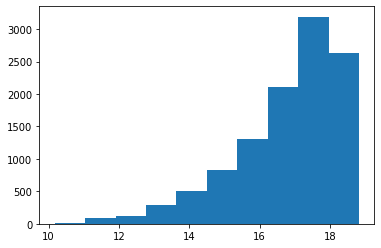

In [113]:
df_pure_groupby = df_pure.groupby('SOURCEID')
df_pure_means = df_pure_groupby.apply(np.mean)
plt.hist(df_pure_means['JAPERMAG3'])

In [58]:
pure_df = df[(df['JPPERRBITS'] == 0) & (df['HPPERRBITS'] == 0) & (df['KPPERRBITS'] == 0) & (df['PSTAR'] > 0.8) & (df['JAPERMAG3'] > 0) & (df['HAPERMAG3'] > 0) & (df['KAPERMAG3'] > 0)]
q2_pure_df = pure_df[(pure_df['JAPERMAG3'] < 17) & (pure_df['HAPERMAG3'] < 16) & (pure_df['KAPERMAG3'] < 16)]
q2_groupby = q2_pure_df.groupby('SOURCEID')

pure_groupby = pure_df.groupby('SOURCEID')


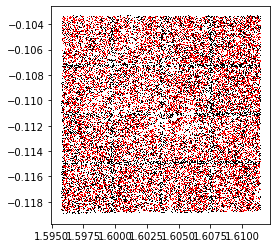

In [114]:
# map

import matplotlib.pyplot as plt
plt.plot(pure_groupby['RA'].aggregate(np.mean).values, pure_groupby['DEC'].aggregate(np.mean).values, 'k,')
ax = plt.gca()
ax.set_aspect('equal')
ax.set_title("")

plt.plot(df_pure.groupby("SOURCEID")['RA'].aggregate(np.mean).values, df_pure.groupby("SOURCEID")['DEC'].aggregate(np.mean).values, 'r,')


In [46]:
agg = q2_groupby['RA'].aggregate(np.mean).values

(8, 20)

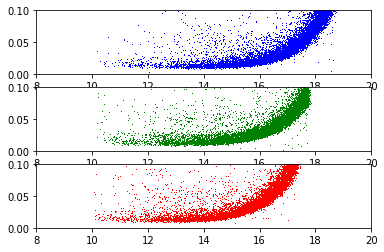

In [115]:
# jhk mags vs observed rms

# df_pure_groupby = df_pure.groupby('SOURCEID')

# plt.subplot(311)
# plt.plot(pure_groupby['JAPERMAG3'].aggregate(np.mean).values, pure_groupby['JAPERMAG3'].aggregate(np.std).values, 'b,')
# plt.ylim(0,0.1)
# plt.xlim(8,20)

# plt.subplot(312)
# plt.plot(pure_groupby['HAPERMAG3'].aggregate(np.mean).values, pure_groupby['HAPERMAG3'].aggregate(np.std).values, 'g,')
# plt.ylim(0,0.1)
# plt.xlim(8,20)

# plt.subplot(313)
# plt.plot(pure_groupby['KAPERMAG3'].aggregate(np.mean).values, pure_groupby['KAPERMAG3'].aggregate(np.std).values, 'r,')
# plt.ylim(0,0.1)
# plt.xlim(8,20)

plt.subplot(311)
plt.plot(df_pure_groupby['JAPERMAG3'].aggregate(np.mean).values, df_pure_groupby['JAPERMAG3'].aggregate(np.std).values, 'b,')
plt.ylim(0,0.1)
plt.xlim(8,20)

plt.subplot(312)
plt.plot(df_pure_groupby['HAPERMAG3'].aggregate(np.mean).values, df_pure_groupby['HAPERMAG3'].aggregate(np.std).values, 'g,')
plt.ylim(0,0.1)
plt.xlim(8,20)

plt.subplot(313)
plt.plot(df_pure_groupby['KAPERMAG3'].aggregate(np.mean).values, df_pure_groupby['KAPERMAG3'].aggregate(np.std).values, 'r,')
plt.ylim(0,0.1)
plt.xlim(8,20)


(8, 20)

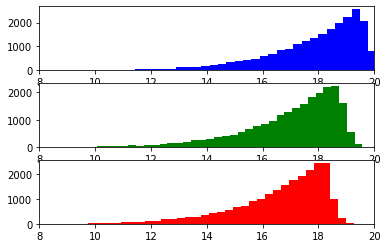

In [43]:
# hist: number of sources

plt.subplot(311)
plt.hist(pure_groupby['JAPERMAG3'].aggregate(np.mean).values, bins=40, color='b')
plt.xlim(8,20)

plt.subplot(312)
plt.hist(pure_groupby['HAPERMAG3'].aggregate(np.mean).values, bins=40, color='g')
plt.xlim(8,20)

plt.subplot(313)
plt.hist(pure_groupby['KAPERMAG3'].aggregate(np.mean).values, bins=40, color='r')
plt.xlim(8,20)

In [48]:
# stetson index vs median H mag

In [116]:
# ok, let's select some variables.

# j band chisq
# chisq = (datapoint - mean)^2 / err^2
# j_chisq = (pure_groupby['JAPERMAG3'] - pure_groupby['JAPERMAG3'].aggregate(np.mean).values)**2 / (pure_groupby['JAPERMAG3ERR']**2)


In [117]:
%run stetson_2020.py

df_pure_stetson = df_pure_groupby.apply(threeband_stetson_pandas)

In [118]:
df_pure_stetson

SOURCEID
45195940855960    0.483624
45195940855963    0.149631
45195940855964    0.538112
45195940855974    0.088970
45195940855975    0.804374
                    ...   
45195940912080    0.468334
45195940912082   -0.162731
45195940912083   -0.099857
45195940912084    0.428223
45195940912089    0.699066
Length: 11101, dtype: float64

Text(0.5, 0, 'Stetson variability index $S$')

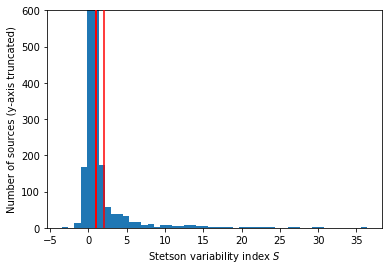

In [133]:
plt.hist(df_pure_stetson, bins=50)
plt.ylim(0,600)
plt.gca().axvline(1, zorder=10, lw=2, color='r')
plt.gca().axvline(2, zorder=10, lw=1.5, color='r')
plt.ylabel("Number of sources (y-axis truncated)")
plt.xlabel("Stetson variability index $S$")

In [ ]:
plt.plot(df_pure_groupby['HAPERMAG3'].app)

In [52]:
pure_groupby['JAPERMAG3'].aggregate(np.mean).values

array([19.316202, 20.00899 , 19.378727, ..., 18.800758, 19.610432,
       19.360136], dtype=float32)

In [115]:
pure_groupby['JAPERMAG3'].aggregate(np.mean)

SOURCEID
45195940855889    19.316202
45195940855893    20.008989
45195940855896    19.378727
45195940855897    19.455702
45195940855901    18.506439
                    ...    
45195940912097    19.277187
45195940912099    15.172639
45195940912100    18.800758
45195940912670    19.610432
45195940912682    19.360136
Name: JAPERMAG3, Length: 22871, dtype: float32

In [56]:
pure_groupby['JAPERMAG3ERR']**2

TypeError: unsupported operand type(s) for ** or pow(): 'SeriesGroupBy' and 'int'

In [57]:
df['JAPERMAG3ERR']**2

0          1.734225e-02
1          1.081999e+18
2          1.081999e+18
3          1.081999e+18
4          1.081999e+18
               ...     
2989611    3.835733e-03
2989612    4.663697e-03
2989613    3.314569e-03
2989614    8.633446e-03
2989615    3.940772e-03
Name: JAPERMAG3ERR, Length: 2989616, dtype: float32

In [122]:
def wavg(group):
    d = group['data']
    w = group['weights']
    return (d * w).sum() / w.sum()

def chisq(group):
    d = group['JAPERMAG3']
    err = group['JAPERMAG3ERR']
    
    return ((d - d.mean())**2 / err**2).sum()

q2_chisq = q2_groupby.apply(chisq)

In [121]:
q2_groupby.apply(np.max)

,SOURCEID,MEANMJDOBS,RA,DEC,JMHPNT,JMHPNTERR,HMKPNT,HMKPNTERR,JAPERMAG3,JAPERMAG3ERR,HAPERMAG3,HAPERMAG3ERR,KAPERMAG3,KAPERMAG3ERR,JPPERRBITS,HPPERRBITS,KPPERRBITS,MERGEDCLASS,PSTAR
SOURCEID,,,,,,,,,,,,,,,,,,,
45195940855904,4.519594e+13,57782.303056,1.599717,-0.117490,0.851140,0.155491,0.344243,0.122610,16.501236,0.105361,15.781550,0.126257,15.551130,0.075065,0.0,0.0,0.0,-1.0,0.999657
45195940855909,4.519594e+13,57782.307600,1.599725,-0.116350,1.135288,0.021391,0.402753,0.010545,13.847465,0.029265,12.926915,0.023500,12.599107,0.021934,0.0,0.0,0.0,-1.0,0.999657
45195940855911,4.519594e+13,57782.303056,1.599703,-0.118748,0.758851,0.083353,0.399657,0.067961,16.291538,0.088381,15.775818,0.041735,15.694120,0.067312,0.0,0.0,0.0,-1.0,0.999657
45195940855920,4.519594e+13,57782.303056,1.599689,-0.118252,0.908706,0.132279,0.339219,0.105665,16.675270,0.138320,15.986814,0.047314,15.754967,0.103558,0.0,0.0,0.0,-1.0,0.999657
45195940855931,4.519594e+13,57782.303056,1.599664,-0.117669,0.909466,0.061958,0.294068,0.048915,15.899490,0.067225,15.165198,0.031804,14.924626,0.050779,0.0,0.0,0.0,-1.0,0.999657
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45195940912066,4.519594e+13,57782.305972,1.603156,-0.103484,0.772411,0.025014,0.383956,0.020473,14.544655,0.027461,13.818681,0.028371,13.470203,0.023035,0.0,0.0,0.0,-1.0,0.999657
45195940912073,4.519594e+13,57782.305972,1.602251,-0.103454,0.533768,0.024999,0.283499,0.022217,14.365052,0.026430,13.873199,0.029319,13.613367,0.023589,0.0,0.0,0.0,-1.0,0.999657
45195940912084,4.519594e+13,57781.475197,1.599953,-0.103414,0.611312,0.083339,0.266995,0.077522,15.775366,0.052409,15.240461,0.075167,15.073748,0.041644,0.0,0.0,0.0,-1.0,0.999657


In [123]:
print(q2_chisq.sort_values()[::-1])

SOURCEID
45195940865381    46050.253906
45195940863452    36849.117188
45195940910843    36303.960938
45195940888623    34014.546875
45195940863558    25736.841797
                      ...     
45195940880267        0.000000
45195940880252        0.000000
45195940903633        0.000000
45195940890767        0.000000
45195940908179        0.000000
Length: 5407, dtype: float64


In [87]:
%run plots

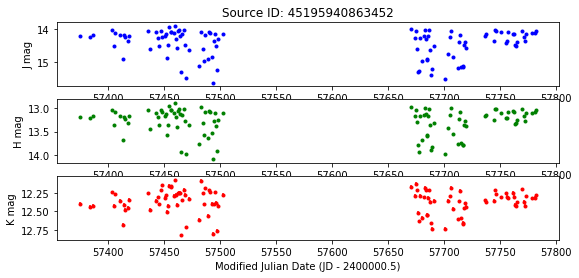

In [125]:
fig = three_plot(q2_pure_df, 45195940863452)

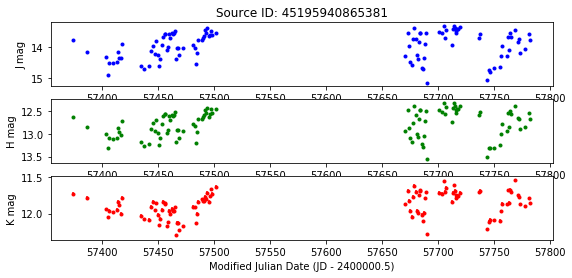

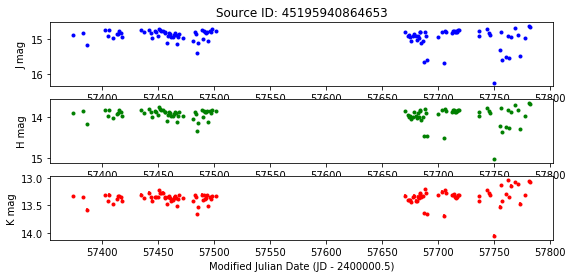

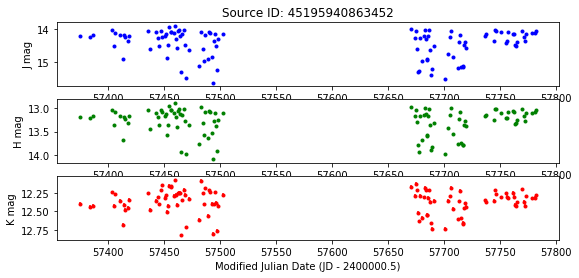

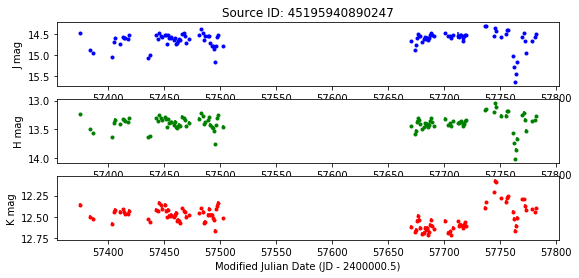

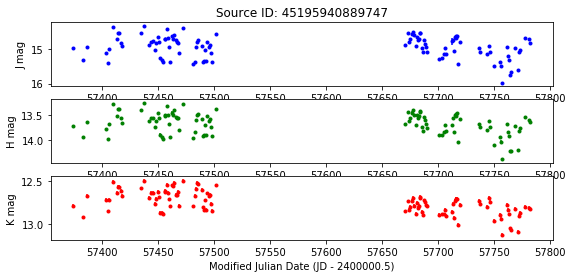

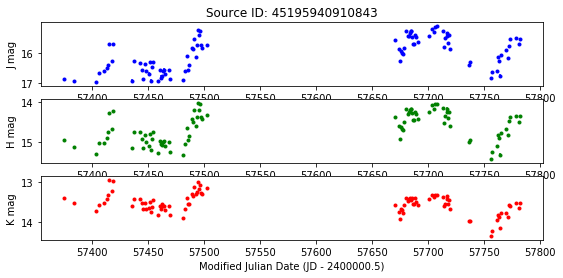

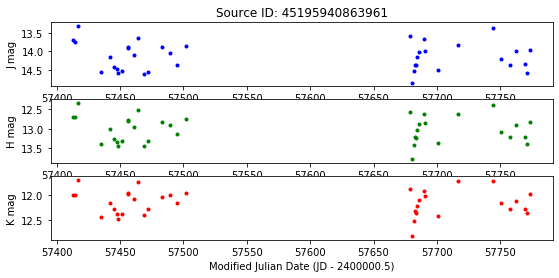

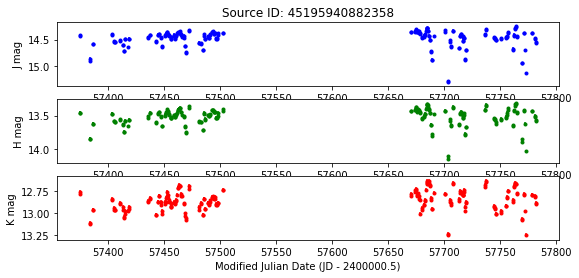

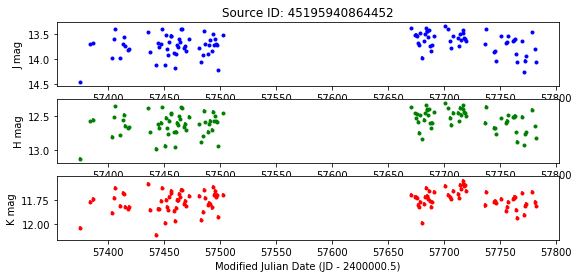

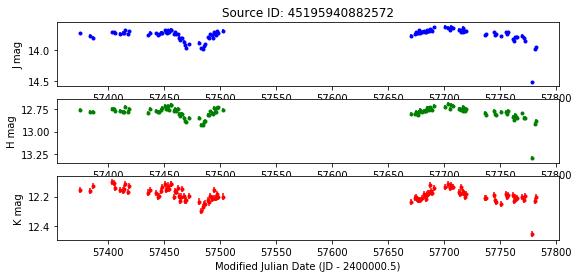

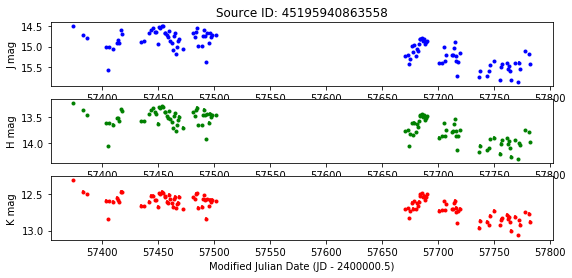

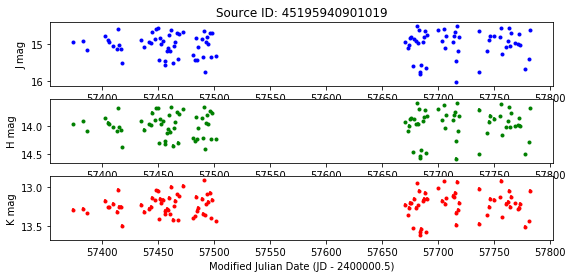

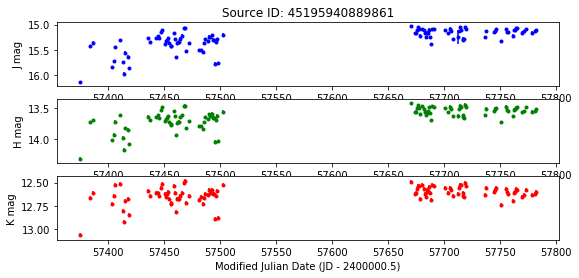

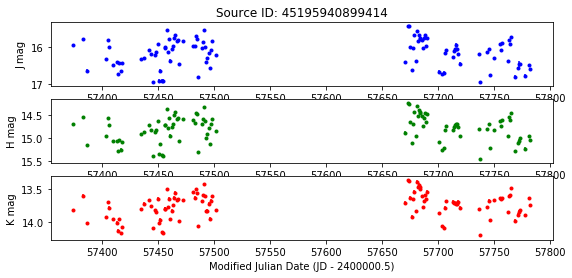

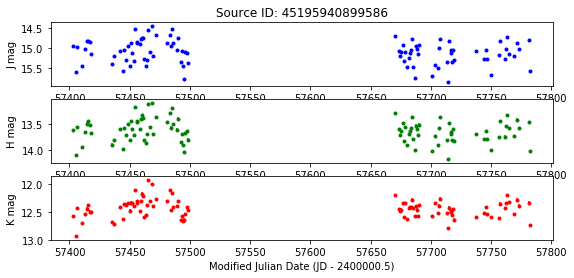

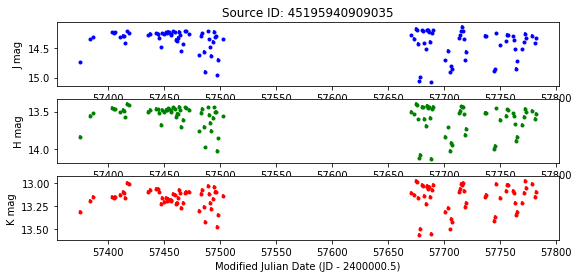

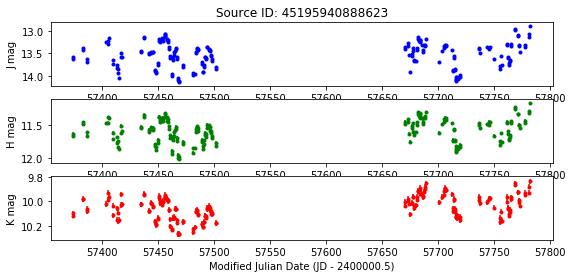

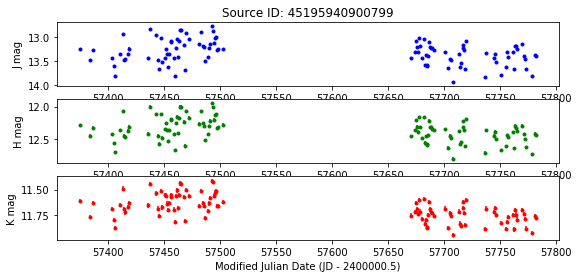

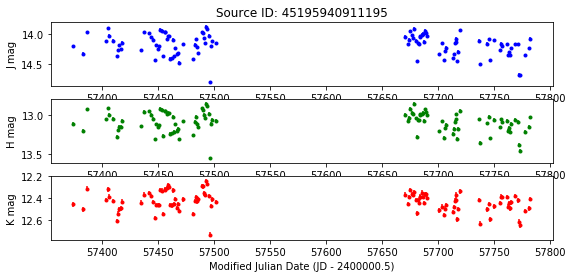

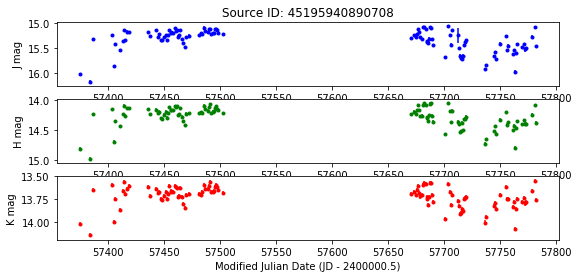

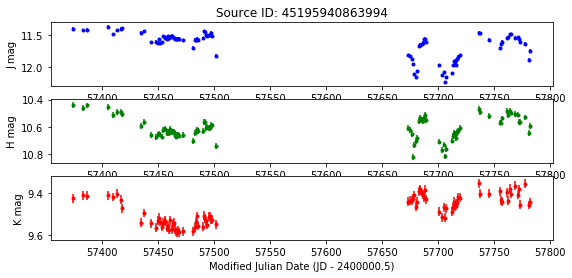

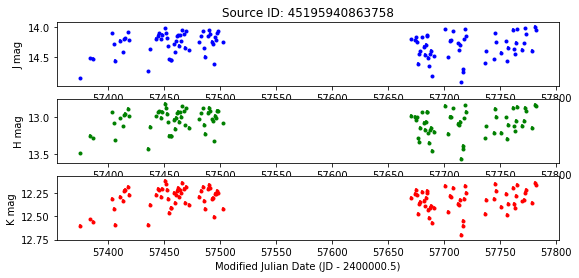

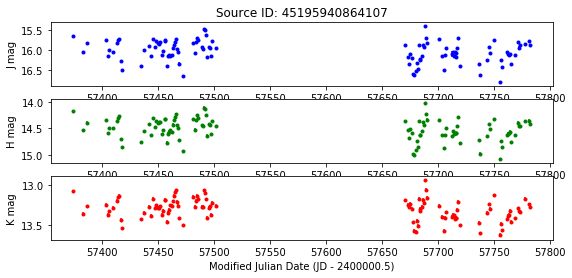

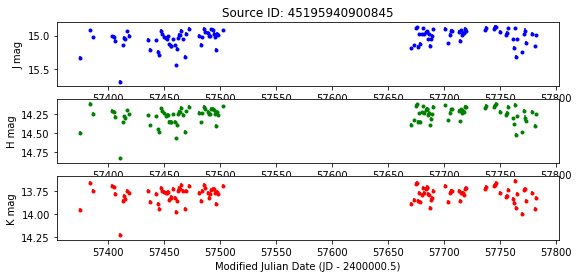

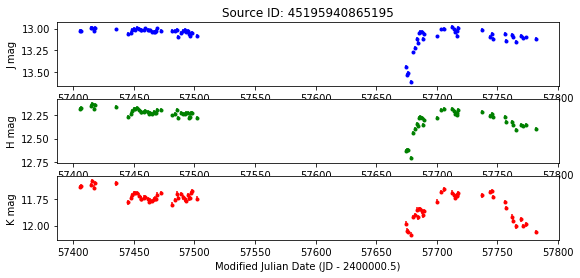

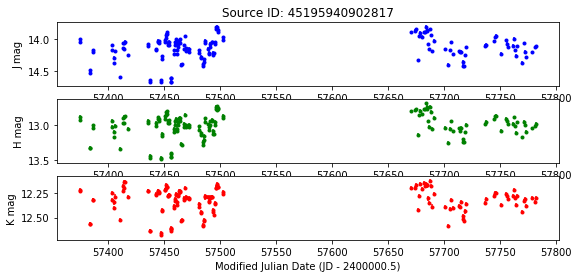

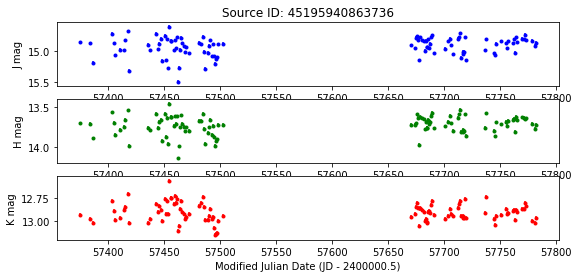

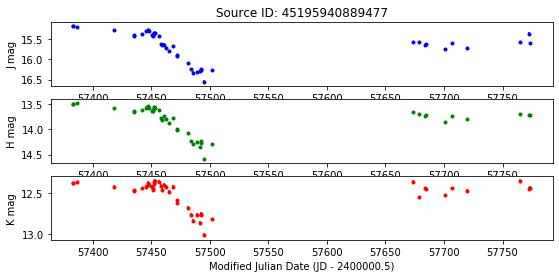

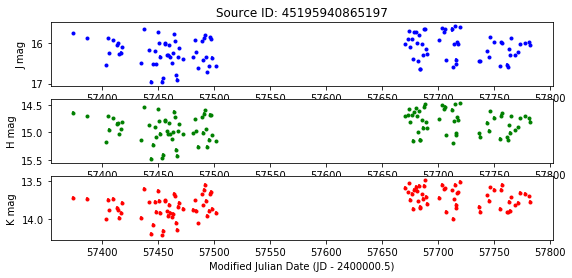

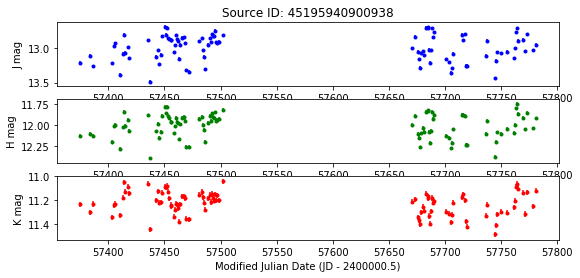

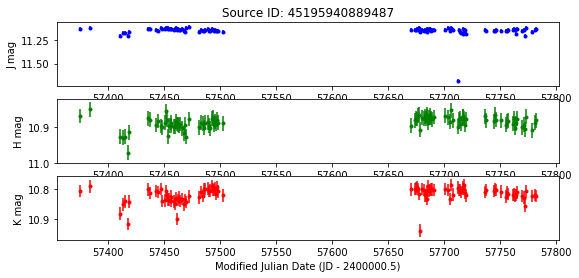

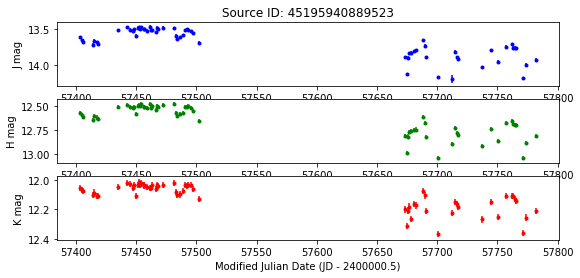

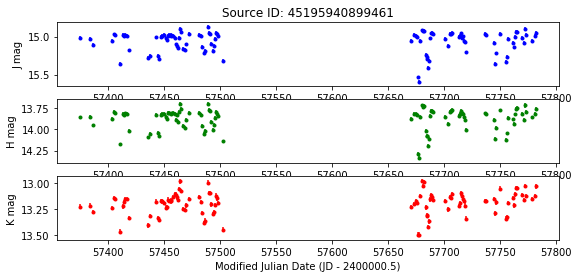

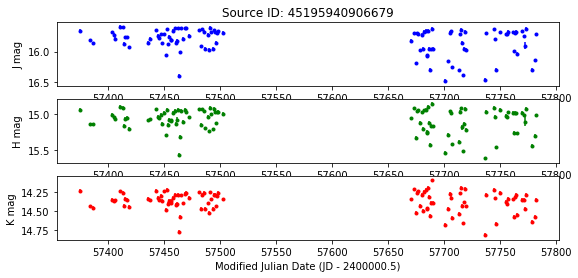

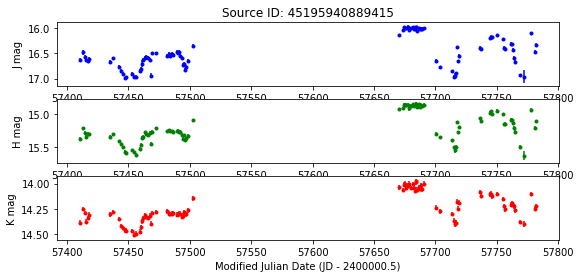

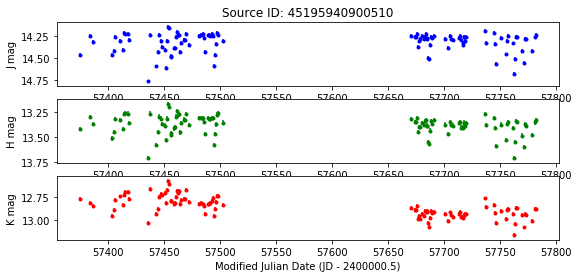

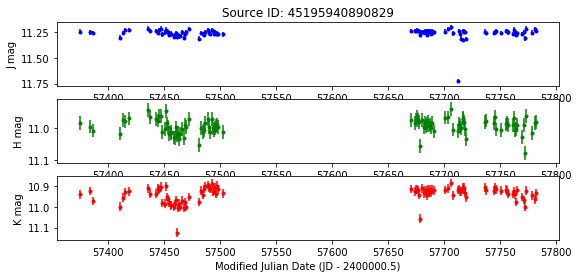

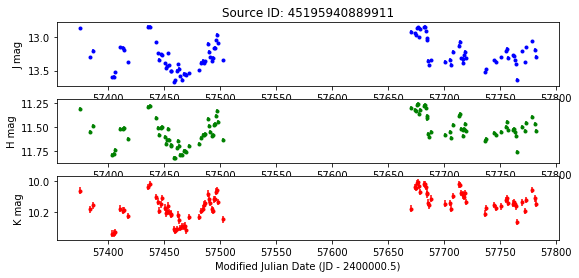

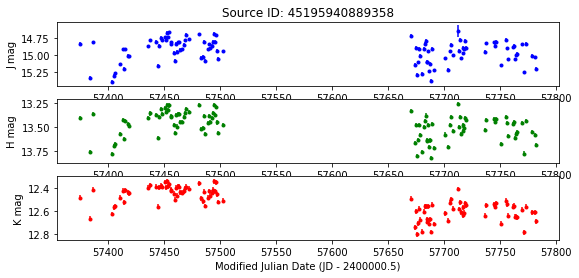

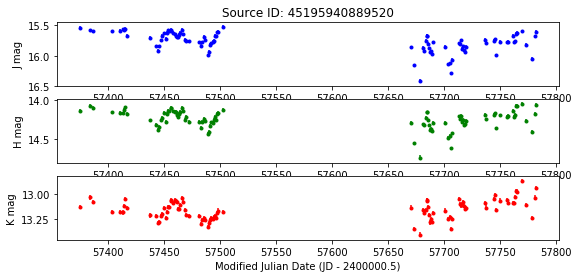

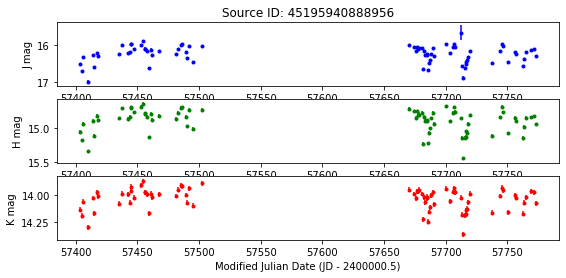

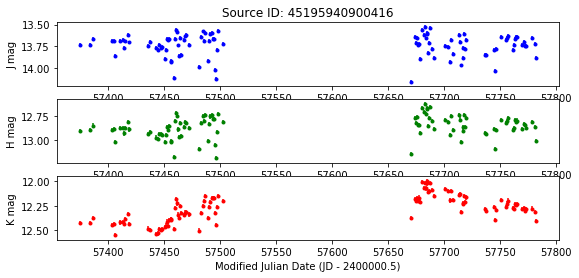

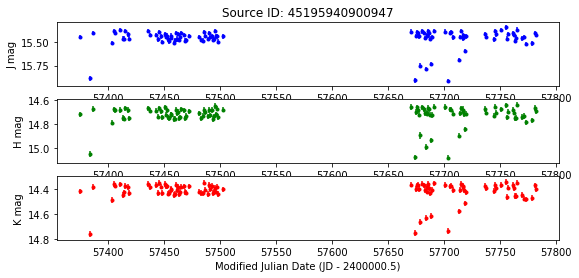

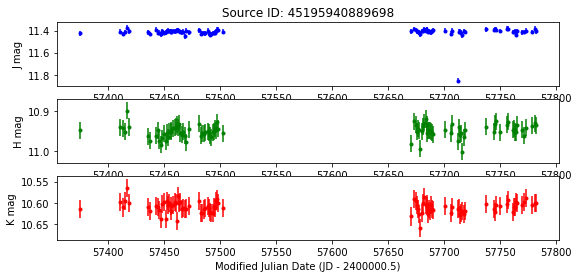

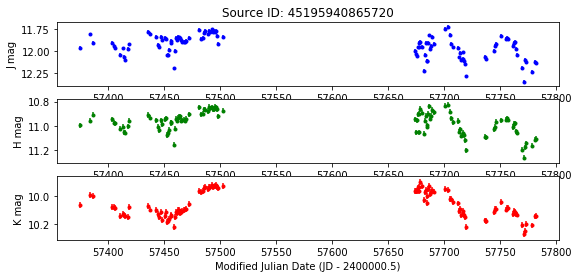

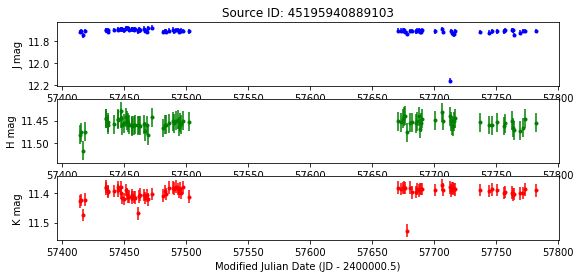

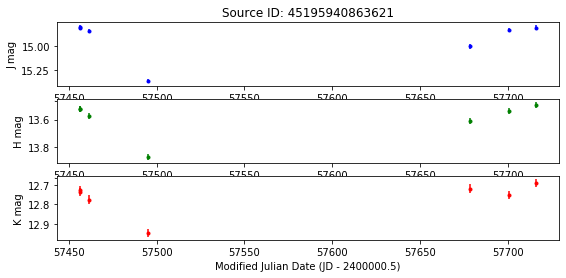

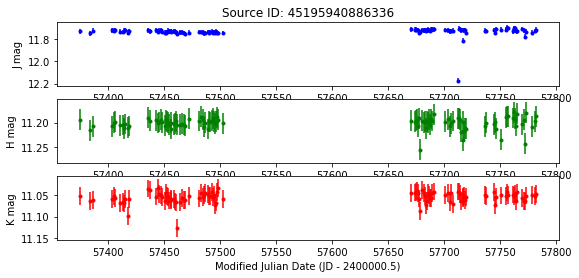

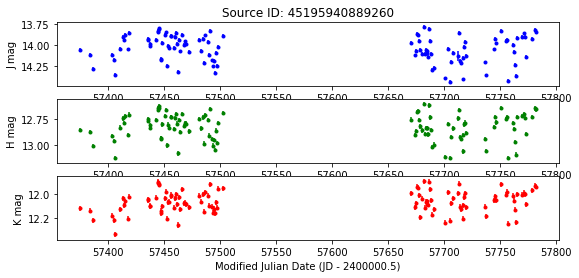

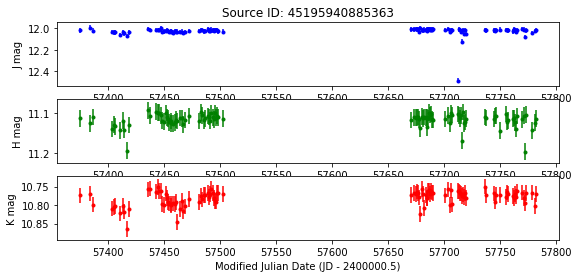

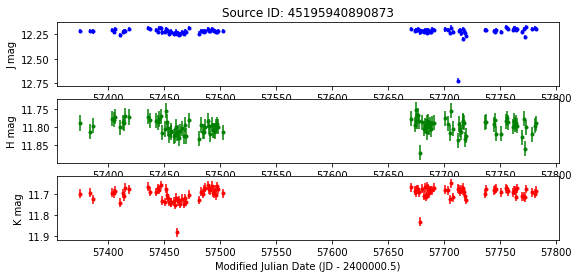

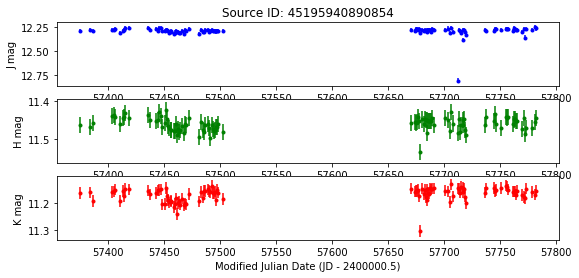

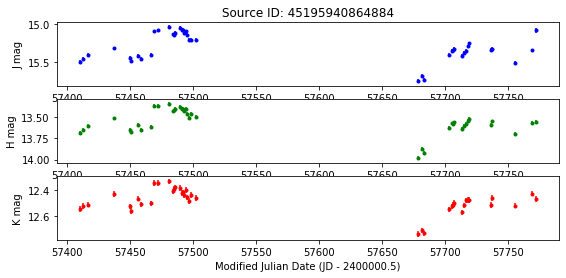

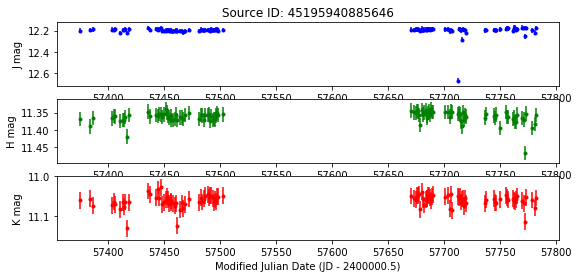

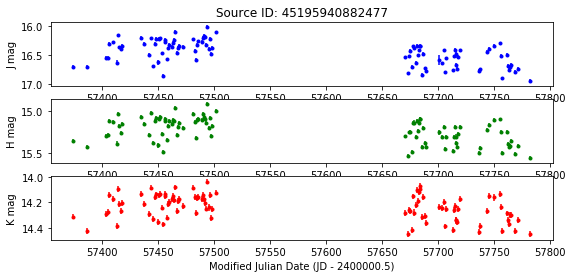

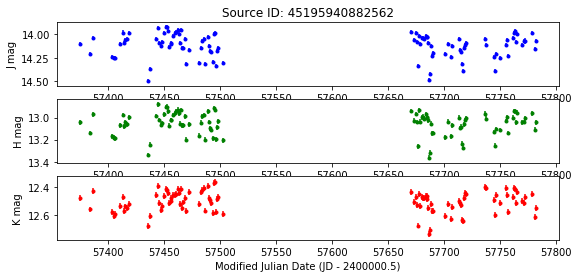

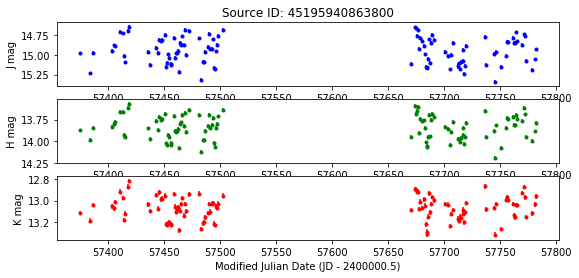

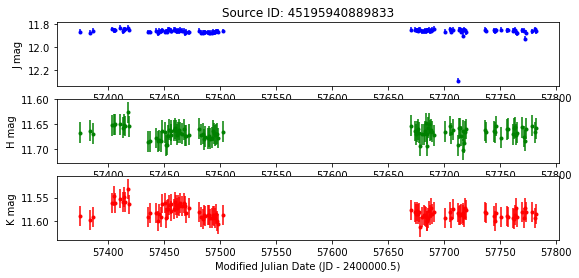

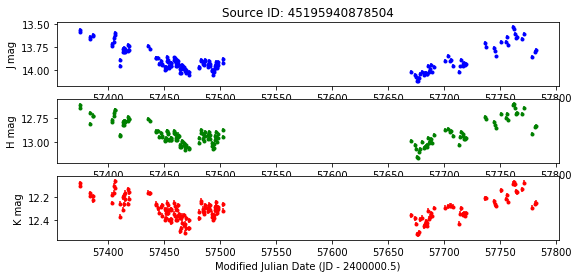

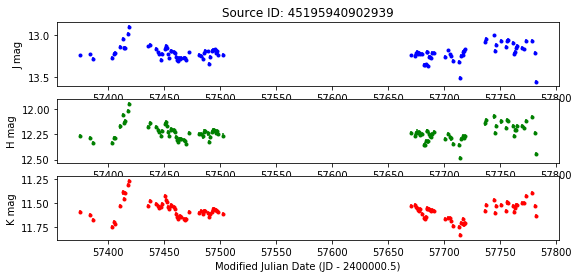

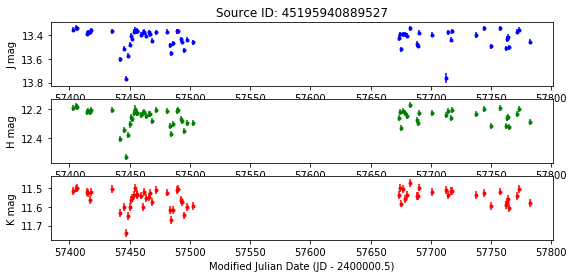

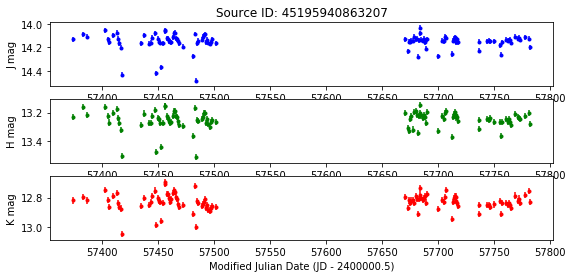

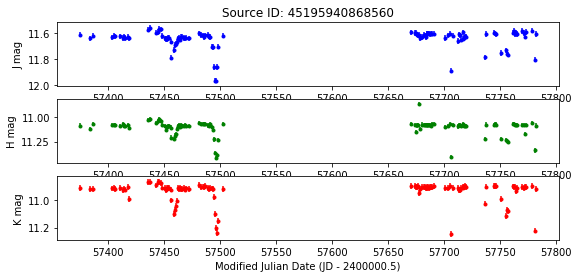

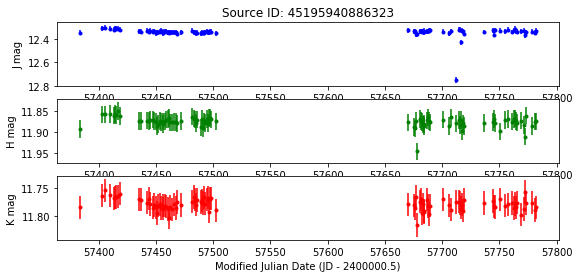

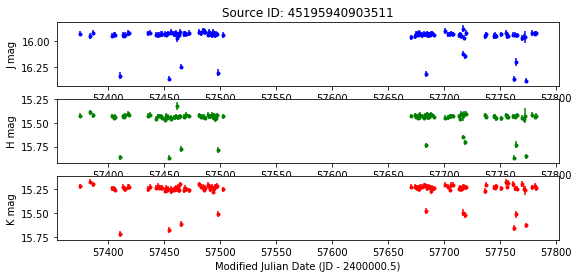

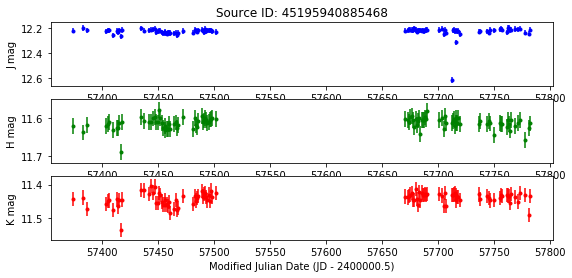

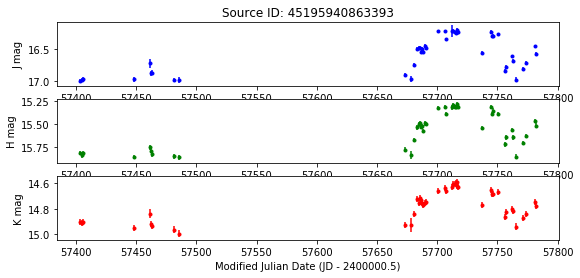

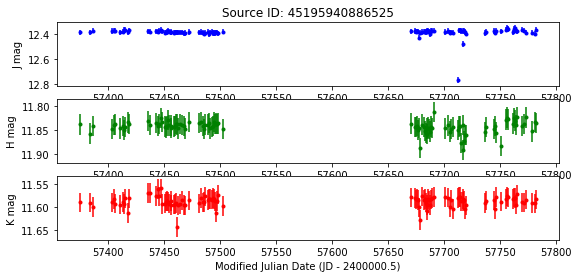

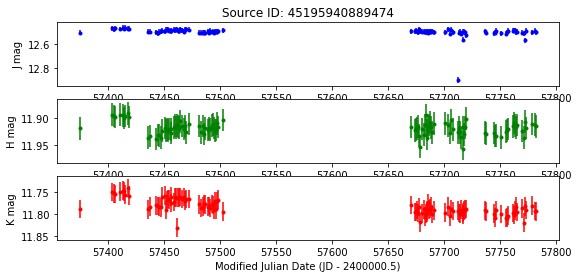

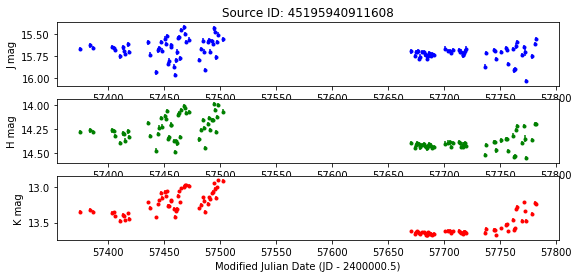

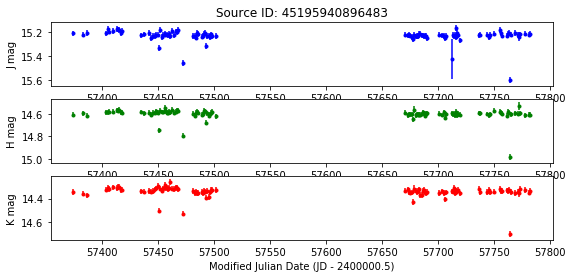

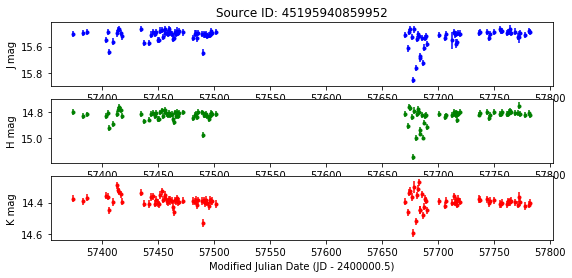

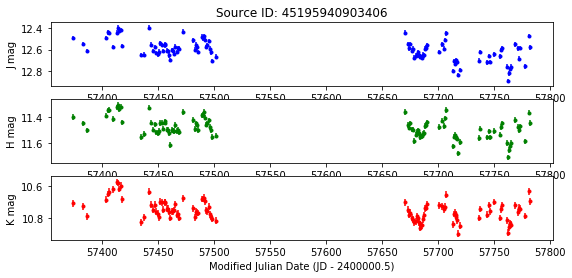

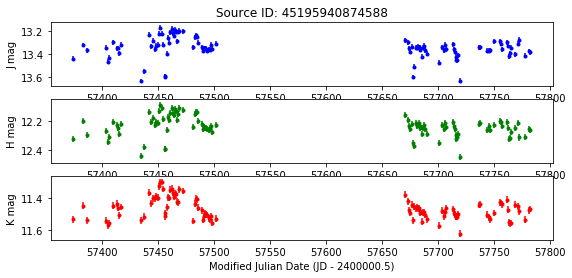

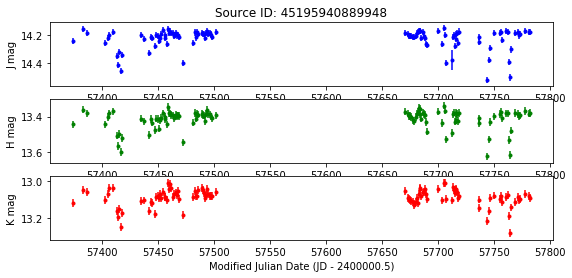

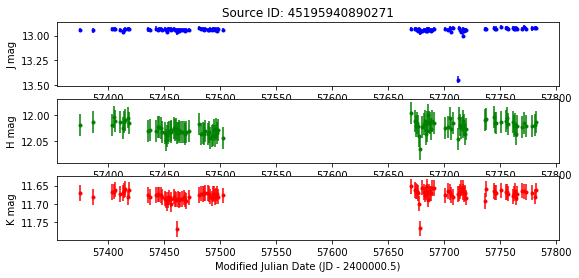

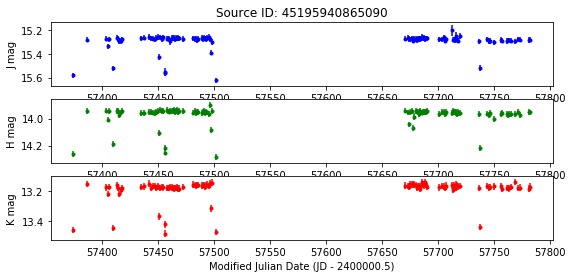

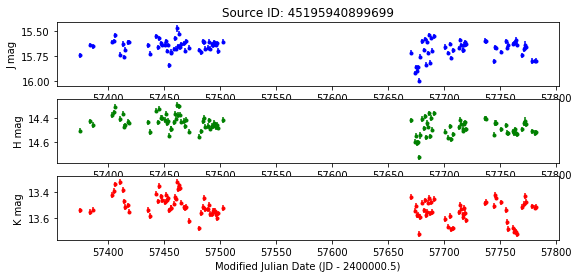

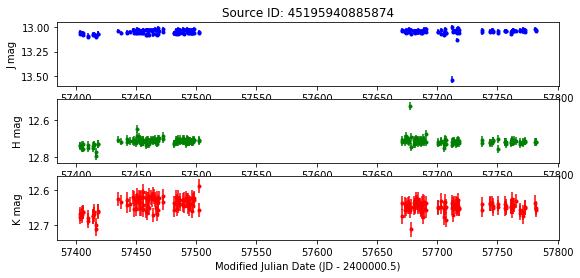

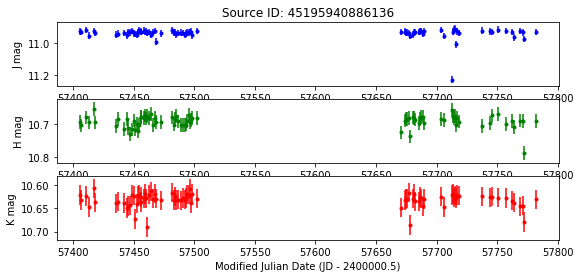

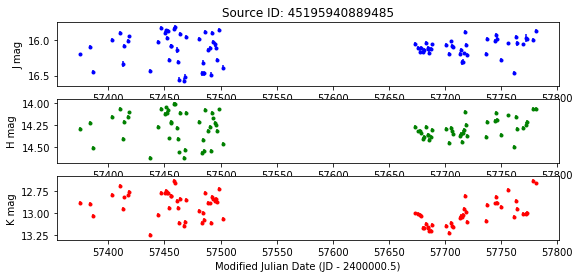

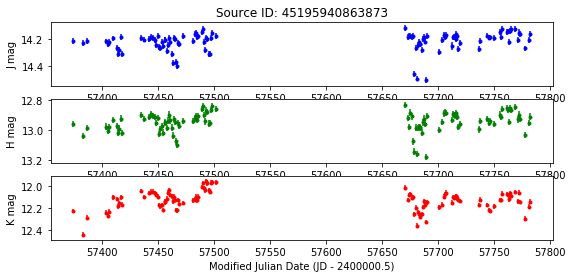

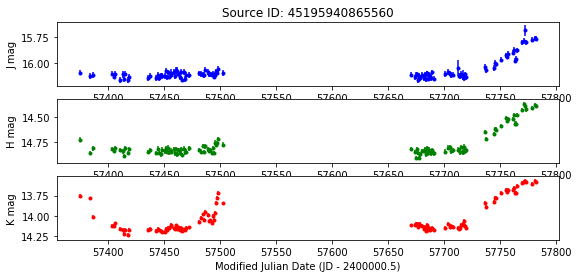

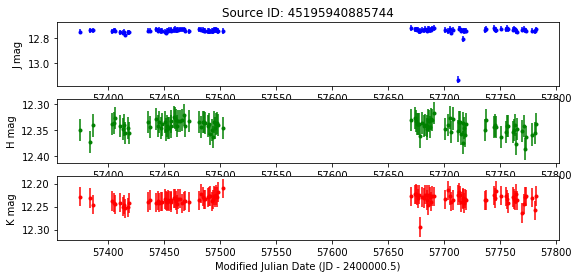

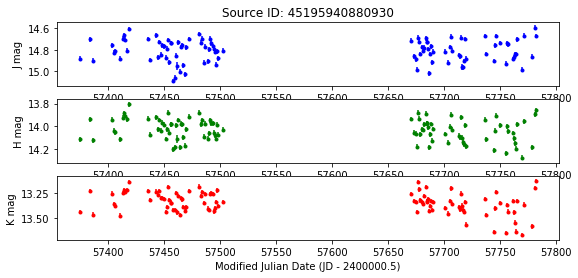

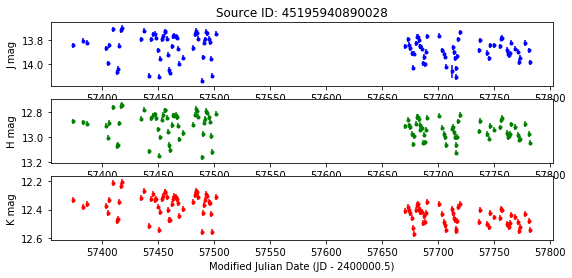

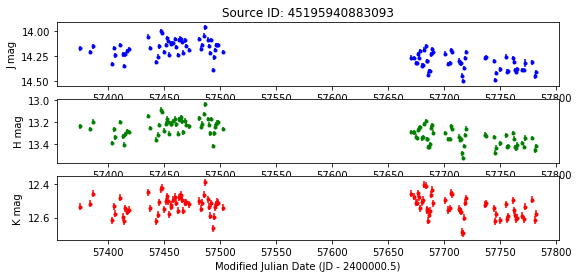

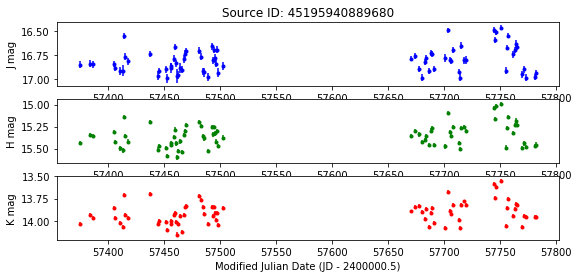

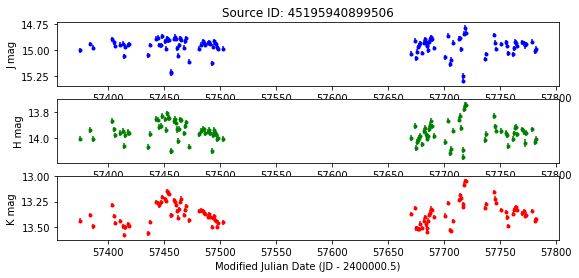

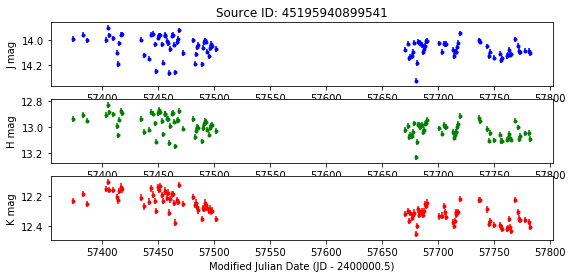

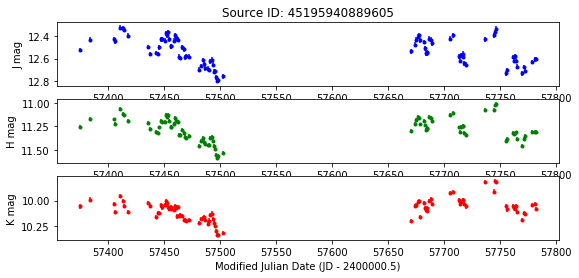

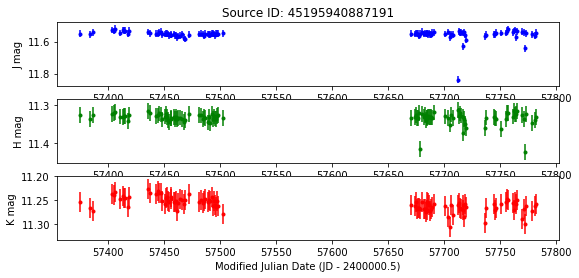

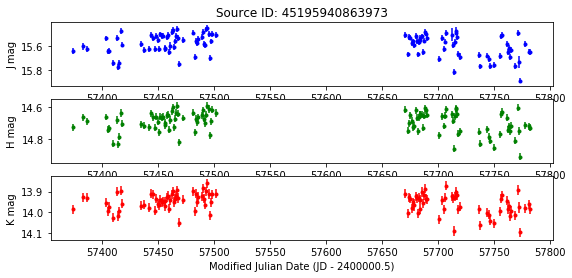

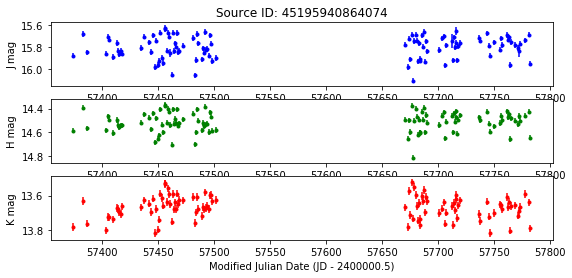

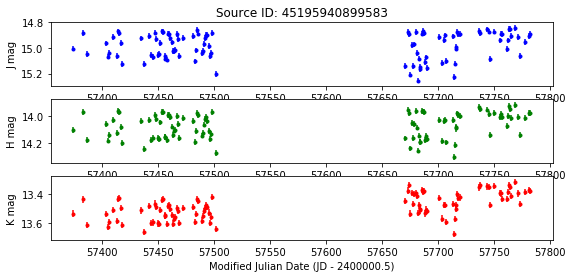

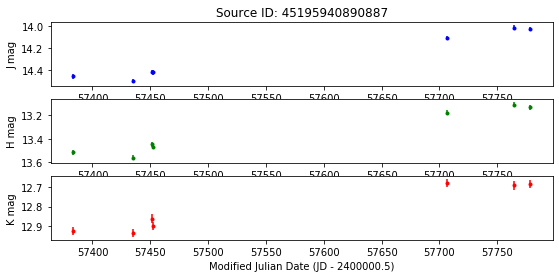

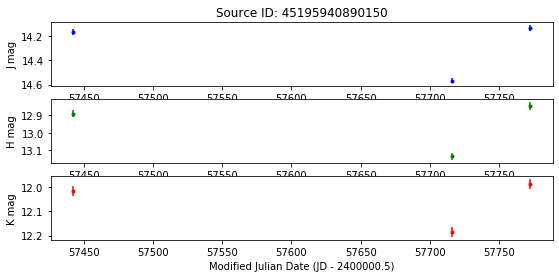

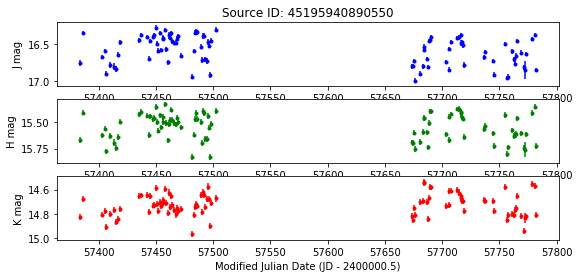

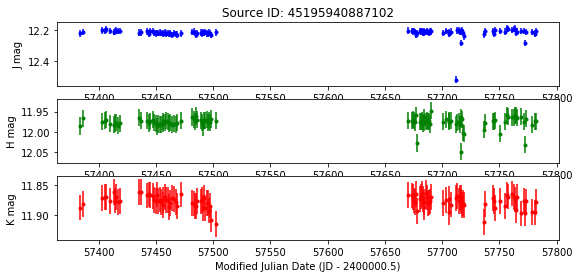

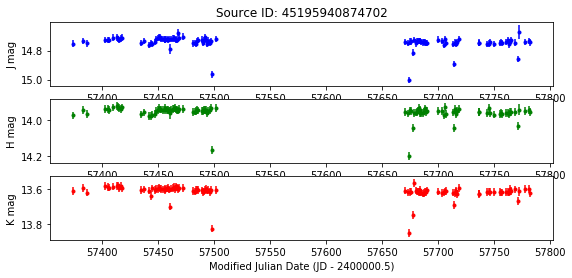

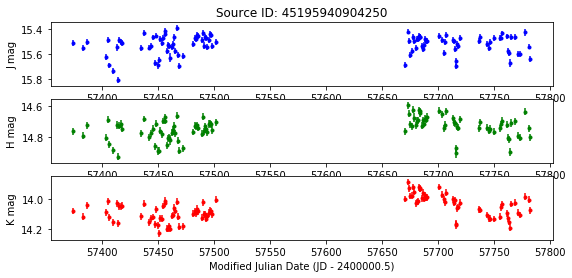

In [109]:
sourceid_set = set()
i = 0
for index in q2_chisq.sort_values()[::-1].index:
    if index[0] not in sourceid_set:
        
        sourceid_set.add(index[0])
        three_plot(q2_pure_df, index[0])
        i+=1
        if i>100: break

In [126]:
for index, row in zip(q2_chisq.sort_values()[::-1].index, q2_chisq.sort_values()[::-1]):
    print(index, row)

45195940865381 46050.25390625
45195940863452 36849.1171875
45195940910843 36303.9609375
45195940888623 34014.546875
45195940863558 25736.841796875
45195940901019 21740.20703125
45195940889747 21175.234375
45195940899414 18712.45703125
45195940899586 15795.560546875
45195940865197 15239.6689453125
45195940900799 14538.4990234375
45195940864653 12551.970703125
45195940902817 12442.736328125
45195940863961 11367.9375
45195940864107 11325.763671875
45195940864452 11292.39453125
45195940882358 11142.498046875
45195940909035 10787.6572265625
45195940889415 10470.224609375
45195940889911 9627.0673828125
45195940890247 9406.630859375
45195940863758 9183.72265625
45195940890708 9012.86328125
45195940863994 8989.3857421875
45195940889861 8156.97119140625
45195940889477 7931.1201171875
45195940900938 7759.45703125
45195940911195 7051.1640625
45195940906679 6919.7724609375
45195940889260 6289.67431640625
45195940889358 6120.05322265625
45195940878504 6006.3251953125
45195940863800 5913.59912109375

45195940876683 78.1616439819336
45195940911323 78.01263427734375
45195940855904 78.001708984375
45195940883706 77.93059539794922
45195940894560 77.86491394042969
45195940868600 77.8595199584961
45195940859546 77.76397705078125
45195940896983 77.75921630859375
45195940871574 77.75716400146484
45195940890823 77.71346282958984
45195940865718 77.63702392578125
45195940906623 77.56817626953125
45195940865726 77.55677032470703
45195940863478 77.49494171142578
45195940882378 77.49404907226562
45195940863503 77.376220703125
45195940868791 77.36455535888672
45195940909192 77.27565002441406
45195940872320 77.17182159423828
45195940892529 77.04151916503906
45195940868446 77.02008056640625
45195940896346 76.86669921875
45195940910432 76.83161163330078
45195940899459 76.78907012939453
45195940910436 76.73622131347656
45195940868001 76.72933959960938
45195940885916 76.63467407226562
45195940896645 76.62289428710938
45195940909014 76.56251525878906
45195940868207 76.45035552978516
45195940869387 76.3

45195940868637 53.84851837158203
45195940882481 53.8410758972168
45195940857801 53.771488189697266
45195940899204 53.757755279541016
45195940876431 53.73630905151367
45195940889820 53.73331069946289
45195940881086 53.73159408569336
45195940865569 53.73016357421875
45195940889033 53.725547790527344
45195940869607 53.71240997314453
45195940882826 53.70555114746094
45195940911044 53.69036102294922
45195940868941 53.6846809387207
45195940881062 53.68222427368164
45195940861285 53.668575286865234
45195940871084 53.642765045166016
45195940883874 53.62676239013672
45195940882844 53.59579849243164
45195940899332 53.58829116821289
45195940863402 53.585289001464844
45195940882590 53.562618255615234
45195940888737 53.550819396972656
45195940871943 53.54634475708008
45195940869671 53.54436492919922
45195940876273 53.5366096496582
45195940861368 53.510101318359375
45195940860974 53.46065902709961
45195940863114 53.43324661254883
45195940876886 53.423912048339844
45195940874540 53.3989372253418
4519

45195940903700 42.941383361816406
45195940893888 42.9337272644043
45195940911119 42.90299987792969
45195940860960 42.8869514465332
45195940857817 42.88679885864258
45195940886211 42.882957458496094
45195940861384 42.86014938354492
45195940874724 42.83860397338867
45195940890461 42.82585906982422
45195940903989 42.80835723876953
45195940890411 42.80014419555664
45195940907725 42.788734436035156
45195940883168 42.78733444213867
45195940871140 42.76493453979492
45195940903959 42.75436019897461
45195940875128 42.75374984741211
45195940880852 42.72624206542969
45195940898022 42.70594024658203
45195940897153 42.68737030029297
45195940869358 42.67279815673828
45195940911848 42.67247009277344
45195940880461 42.67061233520508
45195940876308 42.666439056396484
45195940878867 42.66126251220703
45195940900693 42.65435028076172
45195940899330 42.6463508605957
45195940872011 42.638832092285156
45195940855931 42.63706588745117
45195940868736 42.62480926513672
45195940875224 42.61712646484375
45195940

45195940879499 36.200340270996094
45195940886944 36.19316482543945
45195940875588 36.18711471557617
45195940875157 36.176334381103516
45195940886937 36.17490768432617
45195940859509 36.169029235839844
45195940890478 36.16365432739258
45195940897805 36.15884780883789
45195940878685 36.11753845214844
45195940897977 36.10337448120117
45195940880243 36.102691650390625
45195940911096 36.09620666503906
45195940899287 36.069828033447266
45195940857691 36.05955123901367
45195940903001 36.04280090332031
45195940893906 36.04077911376953
45195940857290 36.01042175292969
45195940883542 36.00991439819336
45195940911423 36.003448486328125
45195940857833 35.99473190307617
45195940911082 35.983177185058594
45195940887310 35.972694396972656
45195940872200 35.972618103027344
45195940907431 35.965797424316406
45195940856251 35.950443267822266
45195940872612 35.93581771850586
45195940879660 35.93141555786133
45195940908095 35.92964553833008
45195940875033 35.90856170654297
45195940874578 35.89115142822265

45195940857439 28.388957977294922
45195940892993 28.368545532226562
45195940900218 28.367557525634766
45195940903678 28.358736038208008
45195940872119 28.35337257385254
45195940880570 28.350751876831055
45195940885838 28.33898162841797
45195940863409 28.317779541015625
45195940907421 28.293621063232422
45195940859648 28.28067398071289
45195940903153 28.262479782104492
45195940910868 28.24761390686035
45195940864400 28.247100830078125
45195940907454 28.20364761352539
45195940892947 28.19944190979004
45195940904279 28.19011116027832
45195940869467 28.183761596679688
45195940880756 28.181188583374023
45195940864489 28.173866271972656
45195940879872 28.164993286132812
45195940886896 28.161327362060547
45195940880108 28.138254165649414
45195940871681 28.12701988220215
45195940863272 28.09966278076172
45195940876316 28.094200134277344
45195940903907 28.06612205505371
45195940893527 28.05862808227539
45195940860661 28.04526138305664
45195940857170 28.028308868408203
45195940904371 27.99120712

45195940857904 17.015625
45195940858100 17.010854721069336
45195940908237 17.0049991607666
45195940879314 16.98932647705078
45195940879097 16.944293975830078
45195940872665 16.940460205078125
45195940865345 16.921716690063477
45195940868442 16.883106231689453
45195940899838 16.826784133911133
45195940910907 16.781389236450195
45195940880680 16.769075393676758
45195940907316 16.761253356933594
45195940912057 16.71025276184082
45195940879690 16.703716278076172
45195940907977 16.66272735595703
45195940870931 16.637304306030273
45195940869676 16.62990951538086
45195940880525 16.629003524780273
45195940899633 16.539348602294922
45195940863373 16.500911712646484
45195940896829 16.487550735473633
45195940864085 16.486845016479492
45195940908141 16.42603302001953
45195940911616 16.341501235961914
45195940890073 16.32411003112793
45195940872514 16.303495407104492
45195940908774 16.29954719543457
45195940911985 16.273332595825195
45195940903244 16.257871627807617
45195940864834 16.23187828063965

In [134]:
np.rad2deg(df['RA'].max())


92.3323934629412

In [135]:
np.rad2deg(df['RA'].min())

91.42850180772294

In [136]:
np.rad2deg(df['DEC'].min())

-6.815548444961362

In [137]:
np.rad2deg(df['DEC'].max())

-5.92068707931278

In [141]:
from astropy.coordinates import SkyCoord
bottomleft = SkyCoord(ra=91.42850180772294*u.degree, dec=-6.815548444961362*u.degree)
bottomleft.to_string('hmsdms')

'06h05m42.8404s -06d48m55.9744s'

In [142]:
topright = SkyCoord(ra=92.3323934629412*u.degree, dec=-5.92068707931278*u.degree)
topright.to_string('hmsdms')

'06h09m19.7744s -05d55m14.4735s'